<a href="https://colab.research.google.com/github/gsoisson/expected_max_clique/blob/main/expected_max_clique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Expected Maximum Clique Problem

## Description Of The Problem

> An advertising company wants to select a group of people in which there exists a **large subset of group members** such that they all know each other. The company only knows the number of persons $n$ in the group and the probability $p$ that two persons in the group know each other.

## Mathematical Modeling

Let $G=(V,E)$ be an undirected graph, where $V=1, 2,..,n$ and $E⊂V×V$. Formally, a clique $C$ is a subset of vertices such that all vertices in $C$ share an edge, $C⊂V$ and $(i,j)∈E$ for any $i,j∈C$.

A clique is said to be :
*   maximal if it is not a subset of a larger clique in $G$ (i.e. a clique with a greater number of vertices)
*   maximum if there is no larger clique in $G$

Then, finding the largest subset of group members such that they all know each other can be formulated as finding the maximum clique in $G$.

Thus, the expected maximum clique problem is : <br />
Given a random graph $G=(V,E)$ of which we only know its number of vertices $n=|V|$ and the probability $p$ that there is an edge between any two vertices, $p=P((i,j)∈E)$ for any $i,j∈V$, what is its expected maximum clique?

## Estimating The Expected Maximum Clique

To achieve this, we propose a method that involves generating a large number of graphs $N$, calculating the maximum clique of each graph, and taking the average. By the law of large numbers, this should give a good approximation of the expected maximum clique when $N$ is sufficiently large, with $N=100$ used in our experiments. The main challenge then becomes calculating the maximum clique of a given graph.

## Maximum Independent Set Formulation Of The Maximum Clique Problem

As shown in class, the maximum clique problem is equivalent to the maximum independent set problem. An independent set $I$ is a subset of vertices in a graph such that there is no edge between any two vertices in the independent set, $I⊂V$ and $i,j∉E$ for any $i,j∈I$. 

So given a graph $G=(V,E)$ in which we want to find a maximum clique, we can construct a complementary graph $G′=(V',E')$ of $G$ where $E'$ is the set of all edges that are not in $E$. Now, if we find a maximum independent set in $G′$ it will be a maximum clique in $G$. Therefore, let us solve the maximum independent set problem in $G'$.

## Different Approaches To The Maximum Independent Set Problem

We propose two ways to solve the maximum independent set problem:
* Solving the 0-1 Linear Programming problem
* Using a simple yet fast algorithm

# Installing Julia And The Required Packages

We recommend you run this notebook on your local machine instead of Google Colab. This is because Google Colab seems to be incompatible with the Plots package that we use at the end to visualize our results. But if you still want to use Google Colab, run the cell below.

<img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Installing Julia
1. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 1, 2 and 3.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

## Checking The Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

## Installing Packages

In [ ]:
import Pkg

Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Graphs")
Pkg.add("GraphPlot")
Pkg.add("Statistics")
Pkg.add("Plots") #This is the package that Google Colab isn't compatible with Google Colab

using JuMP, GLPK, Graphs, GraphPlot, Statistics, Plots

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


# Solving The 0-1 Linear Programming Problem

## Description Of The 0-1 Linear Programming Problem

We introduce the decision variables $x_1, ..., x_n$, $x_i∈\{0, 1\}$, so that $x_i$ is equal to $1$ if it belongs to a clique of $G$, hence an independent set of $G'$, and $0$ otherwise. Then the maximum independent set problem can be formulated as the following 0-1 linear program:

$$ \max \sum_{i \in V} x_i $$

$$ s.t. x_i + x_j ≤ 1, \forall (i,j)∉E $$
$$ x_i∈\{0, 1\}, \forall i∈V $$


which we can solve using Julia's JuMP and GLPK libraries.

## Implementation

In [ ]:
function max_independent_set1(G)

  model = Model(GLPK.Optimizer)

  @variable(model, x[1:nv(G)], Bin)
  @constraint(model, independence[e in 1:ne(G)], x[src(collect(edges(G))[e])] + x[dst(collect(edges(G))[e])] <= 1 ) 
  @objective(model, Max, sum(x[i] for i in 1:nv(G)))

  optimize!(model)

  if (termination_status(model)== MOI.OPTIMAL)
    return Int(objective_value(model))
  else
    println("Problem has not an optimal solution")
    return -1
  end

end

max_independent_set1 (generic function with 1 method)

In [ ]:
function complementary_graph(G)

   H = complete_graph(nv(G))
   for e in collect(edges(G))
        rem_edge!(H, e)
   end

   return(H)
end


function max_clique1(G)

    H = complementary_graph(G)
    return max_independent_set1(H)
end

max_clique1 (generic function with 1 method)

## Testing

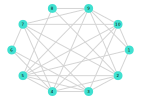

In [ ]:
G = erdos_renyi(10, 0.5)
gplot(G,layout=circular_layout,nodelabel=collect(1:nv(G)))

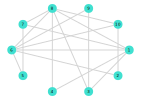

In [ ]:
H = complementary_graph(G)
gplot(H,layout=circular_layout,nodelabel=collect(1:nv(H)))

In [ ]:
time = @elapsed opt = max_clique1(G)

println("")
println("Maximum clique size: ", opt)
println("Time to compute: ", time)


Maximum clique size: 4
Time to compute: 6.219855375


## Time Complexity

The branch-and-cut algorithm used by GLPK to solve a mixed-integer linear programming problem (MILP) combines the branch-and-bound algorithm with linear programming relaxation and cutting plane techniques to efficiently explore the search tree and find an optimal solution. 
<br /> <br />
The worst-case time complexity of this algorithm can be expressed as $O(b^n)$, where $b$ is the branching factor, or the maximum number of children that any node in the search tree can have, and $n$ is the depth of the tree, or the number of decision variables that have been fixed to values at each point in the search. In practice, the worst-case time complexity is rarely achieved, and the running time depends on the specific problem being solved, the quality of the problem formulation and the chosen branching and bounding strategies.
<br /> <br />
However, in the case of finding the maximum clique in large and sparse graphs as is our case, or rather in the case of finding a maximum independent set in their large and connected complementary graphs, the time complexity can prove to be especially high, and close to the worst case scenario.
<br /> <br />
Indeed, GLPK first uses linear relaxation to obtain an initial feasible solution to the MILP. When the MILP is first solved, GLPK solves the relaxed linear program and rounds the resulting solution to obtain a feasible solution to the MILP. This initial feasible solution serves as the starting point for the branch-and-cut algorithm that is used to search for the optimal solution. Additionally, GLPK uses linear relaxation to obtain bounds on the optimal objective value of the MILP, as well as for finding good feasible solutions to the MILP quickly.
<br /> <br />
But in the case of large and connected graphs, the relaxed optimum of the maximum independent set problem can be very far from the optimum of its corresponding 0-1 LP problem, therefore increasing the branching factor b, and the time complexity drastically.
<br /> <br />
Indeed, in the LP relaxation, we always have the feasible solution $x_i=\frac{1}{2}$ for any $i∈I$, meaning the optimum is at least $\frac{|V|}{2} = \frac{n}{2}$.
However, if $G$ is a complete graph, the optimum of the 0-1 linear program is always $1$, since every vertex is connected to all the other vertices.
<br /> <br />
In fact, we know since J. Hastad (1999): "Clique is hard to approximate within $n^{1-\epsilon}$", that for any $\epsilon>0$, unless $NP=P$, there is no polynomial-time algorithm that approximates the optimum of the maximum clique problem within a factor of $n^{\frac{1}{2}-\epsilon}$. Therefore, when solving the maximum clique problem in large and sparse graphs using GLPK, the error between the optimum in the LP relaxation and the 0-1 linear program, and thus the branching factor $b$, is bound to be significant, resulting in a high time complexity.
<br /> <br />
This motivates the need for a better and more efficient algorithm, one that doesn't rely on any approximation method.

# A Simple Yet Fast Algorithm



## Description Of The Algorithm

In this approach, we use a recursive algorithm that divides the cases according to the degree of each vertex. After processing it, we remove the vertex from the remaining graph and if we have included it in the independent set, we also remove all its neighbors. Here is the case distinction:

* If there is a vertex with degree zero or one we always include it in the independent set. Because if it has degree zero then it is independent from every other vertex and if it has degree one then there is always a maximum independent set that contains it. <br />
 **Proof of the $2^{nd}$ assertion**: Let $v_1$ be a vertex of degree $d_1=1$ and $v_2$ be its neighbor of degree $d_2≥1$ (when $v_2$ is of degree $0$ we can arbitrarily choose to include one of the two vertices in the independent set). If we choose to include  $v_2$ in the independent set then we need to remove $v_1$, $v_2$, as well as all the neighbors of $v_2$ from the remaining graph. If we choose $v_1$ however, we only need to remove $v_1$ and $v_2$ from the remaining graph. Finally, the first case's vertices are a subset of the second case's vertices therefore, choosing to include $v_1$ instead of $v_2$ always yields a maximum independent set.

* If there is a vertex with degree of at least three, either it is included in a maximum independent set or it is not, so we explore both cases and take the maximum size of the independent sets we find.

* If all the remaining vertices have degree two then the graph is a collection of cycles. In this case, the maximum independent set size of the graph is the sum of the maximum independent set size of every strongly connected component, where their maximum independent set size is simply the floor of their number of vertices devided by two.




## Implementation

In [ ]:
function max_independent_set2(G,i)

  if nv(G) == 0
    return i
  end

  for v in vertices(G)

    d = length(all_neighbors(G,v))

    if d == 0 || d == 1
      vertices_to_remove = append!([v], neighbors(G,v))
      rem_vertices!(G, vertices_to_remove, keep_order=false)
      return max_independent_set2(G,i+1)
    end

    if d >= 3
      G1, G2 = copy(G), copy(G)

      rem_vertex!(G1,v)
      vertices_to_remove = append!([v], neighbors(G2,v))
      rem_vertices!(G2, vertices_to_remove, keep_order=false)

      return max(max_independent_set2(G1,i), max_independent_set2(G2, i+1))
    end
  end
  
  # All vertices have now a degree equal to 2 in the following lines
  cycles = connected_components(G)
  res = 0
  for cycle in cycles
    res += floor(length(cycle)/2)
  end
  
  return res
end


max_independent_set2 (generic function with 1 method)

In [ ]:
function max_clique2(G)

  H = complementary_graph(G)

  return max_independent_set2(H,0)
end

max_clique2 (generic function with 1 method)

## Testing

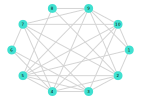

In [ ]:
gplot(G,layout=circular_layout,nodelabel=collect(1:nv(G)))

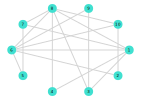

In [ ]:
gplot(H,layout=circular_layout,nodelabel=collect(1:nv(H)))

In [ ]:
time = @elapsed opt = max_clique2(G)

println("")
println("Maximum clique size: ", opt)
println("Time to compute: ", time)


Maximum clique size: 4
Time to compute: 0.325562167


## Time Complexity

Finding connected components can be done in linear time in the case of cycles, and the algorithm also runs in linear time if we repeatedly end up in case where $d=1$. Therefore, its running time is dominated by repeatedly ending up in the case where $d=3$.
<br /> <br />
Let $T(n)$ be the time complexity of this algorihtm. We then have:
$$ T(n) = T(n-1) + T(n-4) + n^c \text{ (1)} $$
Indeed, $T(n-1)$ is the time complexity of finding the maximum independent set in $G1$, $T(n-4)$ is the time complexity of finding the maximum independent set in $G2$ which has at least $4$ vertices less than $G$, and $n^{c}$ is the time complexity of finding the neighbors of $v$ and deleting them as well as $v$ from the remaining graph.
<br /><br />
After solving the recurrence relation $(1)$, we find that the time complexity of this algorithm is $O(1.38^n)$.
<br /><br />
While it may not be the fastest algorithm there is, as the fastest algorithm known today (Robson (2001)) has a time complexity of $O(1.1888^n)$, it is one of if not the most simple algorithm to implement among the fastest algorithms.

# Comparison Between The Two Algorithms

In [ ]:
N = 100
n = 20
p = [0.1, 0.3, 0.5, 0.7, 0.9]

results1 = [[] for k in 1:length(p)]
results2 = [[] for k in 1:length(p)]

for k in 1:length(p)
  for l in 1:N
    G = erdos_renyi(n, p[k])
    time1 = @elapsed opt1 = max_clique1(G)
    time2 = @elapsed opt2 = max_clique2(G)
    append!(results1[k], [time1])
    append!(results2[k], [time2])
  end
end


results1 = [mean(v) for v in results1]
results2 = [mean(v) for v in results2]

println("Total time to compute of the first algorihm: ", sum(results1))
println("Total time to compute of the second algorihm: ", sum(results2))


Total time to compute of the first algorihm: 0.015594926259999998
Total time to compute of the second algorihm: 0.0011359945100000001


We remark that as expected, the simple yet fast algorithm is way faster than GLPK's algorithm. We will thus use this algorithm going forward.

# Visualizing Results

In [ ]:
function expected_max_clique(n,p,N)
  res = 0
  for k in 1:N
    G = erdos_renyi(n,p)
    res += max_clique2(G)
  end

  return res/N
end

expected_max_clique (generic function with 1 method)

In [ ]:
# You should expect this cell to take around 2 minutes to compute

N = 100
n_range = [5*i for i in 1:10]
p_range = range(0.,1.,50)

emc_range = [expected_max_clique(Int(n),p,N) for p in p_range, n in n_range]

50×10 Matrix{Float64}:
 1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0
 1.19   1.57   1.93   1.99   2.0    2.02   2.08   2.05   2.15   2.15
 1.42   1.85   2.06   2.04   2.13   2.23   2.32   2.42   2.58   2.7
 1.45   1.96   2.04   2.17   2.32   2.57   2.75   2.88   2.93   2.98
 1.58   2.08   2.11   2.4    2.69   2.82   2.93   3.01   3.04   3.03
 1.6    2.08   2.3    2.63   2.9    2.97   3.03   3.15   3.13   3.17
 1.74   2.21   2.5    2.82   3.01   3.09   3.14   3.28   3.3    3.56
 1.84   2.38   2.61   3.0    3.08   3.17   3.28   3.53   3.55   3.76
 1.88   2.36   2.78   3.07   3.2    3.27   3.55   3.74   3.83   3.99
 1.86   2.4    2.85   3.16   3.3    3.57   3.79   3.94   4.0    4.12
 ⋮                                  ⋮                          
 3.77   6.11   8.31  10.41  11.51  12.7   13.84  14.89  15.8   16.56
 4.07   6.19   8.77  10.59  12.07  13.55  14.86  15.86  16.8   17.95
 4.0    6.68   9.24  11.19  13.08  14.62  15.97  17.39  18.41  19.49
 4.24   7.01   9.5

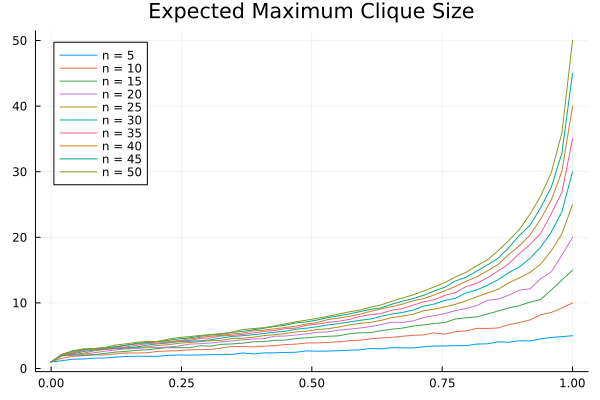

In [ ]:
labels = ["n = 5" "n = 10" "n = 15" "n = 20" "n = 25" "n = 30" "n = 35" "n = 40" "n = 45" "n = 50"]
plot(p_range, emc_range, title="Expected Maximum Clique Size", label=labels)

As we can observe, the curve is almost linear for $p≤0.75$, and becomes exponential for values of $p$ close to $1$. This is due to the fact that to reach the highest numbers of clique size, the graph needs to be almost complete. 